**Предсказание конечной температуры расплава при производстве стали**

В наличии 7 датасетов с различной информацией полученной при производсвте стали. Необходимо разработать модель машинного обучения для предсказания итоговой (кондиционной) температуры расплава на основе ряда вводных данных.
Одно из условий предобработки: аномалиями в сырых данных являются температуры ниже 1500 градусов Цельсия и сильно отрицательная мощность. Любые остальные данные можно исключать только из обучающей выборки.

Ожидается, что полученная модель позволит сократить число итераций подогрева расплава и как следствие снизит затраты на энергопотребление и повысит стабильность технологического процесса

Загрузим все необходимые библиотеки

In [591]:
import pandas as pd


import seaborn as sns

from matplotlib import pyplot as plt

import numpy as np


import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor, plot_importance

from skopt import BayesSearchCV

from skopt.space import Real, Categorical, Integer

Зададим константы

In [592]:
colors_list = ['aqua', 
               'black', 
               'blue', 
               'brown',
               'chartreuse',
               'chocolate',
               'coral',
               'teal',
               'darkblue',
               'darkgreen',
               'fuchsia',
               'gold',
               'green',
               'grey',
               'indigo',
               'maroon',
               'olive',
               'orange',
               'orchid',
               'red'
              ]
RANDOM_STATE = 110423
N_ITER = 10
CV = 7
SCORING = 'neg_mean_absolute_error'
MAX_DEPTH = 10
N_ESTIMATORS = 500
MIN_SAMPLES_LEAF = 20
MIN_SAMPLES_SPLIT = 20
MIN_DATA_IN_LEAF = 30
METHOD = 'log-uniform'

# Знакомство с данными

## Информация об электродах

In [593]:
try: 
    data_arc = pd.read_csv('data_arc.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
display(data_arc.head(10))
print()
print(data_arc.info())
data_arc.describe()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Сразу удалим разрешенные к удалению аномалии: Значения ниже нуля

In [594]:
anomaly_power = list(data_arc[data_arc['Активная мощность'] < 0]['key'])
anomaly_power.extend(list(data_arc[data_arc['Реактивная мощность'] < 0]['key']))
anomaly_power

[2116]

Всего одно такое значение

In [595]:
data_arc = data_arc.query('key not in @anomaly_power')

Переведем даты в формат дат

In [596]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Посмотрим зависимость активной и реактивной мощности

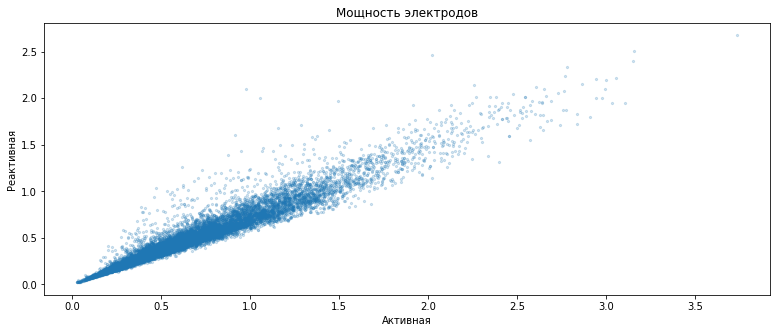

In [597]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))
ax.scatter(data=data_arc,
           x='Активная мощность',
           y='Реактивная мощность',
           s=5,
           alpha=0.2
           )
ax.set_xlabel('Активная')
ax.set_ylabel('Реактивная')
ax.set_title('Мощность электродов')
plt.show()

In [598]:
data_arc[data_arc['Реактивная мощность'] > -5].corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021311,-0.000091
Активная мощность,-0.021311,1.000000,0.963180
Реактивная мощность,-0.000091,0.963180,1.000000


Заметна четкая корреляция между активной и реактивной мощностью

Добавим новый признак - длительность нагрева расплава

In [599]:
data_arc['Длительность нагрева дугой'] = (data_arc['Конец нагрева дугой'] -
                                          data_arc['Начало нагрева дугой']).dt.total_seconds()

In [600]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157.0
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180.0
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184.0
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57.0


Добавим признак для полной мощности, затраченной при нагреве электрода и признак полной работы

In [601]:
data_arc['Полная мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5
data_arc['Работа'] = data_arc['Полная мощность'] * data_arc['Длительность нагрева дугой']

Агрегация признаков по партиям и вычисление суммарных, средних и других значений - создаем новые признаки

In [602]:
data_arc_pivot = data_arc.pivot_table(values=list(data_arc.loc[:, 'Начало нагрева дугой':'Работа'].columns), 
                                      index='key', 
                                      aggfunc={'Активная мощность':'mean',
                                               'Реактивная мощность':'mean',
                                               'Длительность нагрева дугой':'sum',
                                               'Полная мощность':'mean',
                                               'Работа':['sum', 'count', 'mean']})

In [603]:
data_arc_pivot = data_arc_pivot.reset_index()
data_arc_pivot.columns = [' '.join(col) for col in data_arc_pivot.columns]
data_arc_pivot

,key,Активная мощность mean,Длительность нагрева дугой sum,Полная мощность mean,Работа count,Работа mean,Работа sum,Реактивная мощность mean
0,1,0.975629,1098.0,1.165279,5,288.475551,1442.377754,0.636648
1,2,0.763150,811.0,0.912304,4,220.308391,881.233565,0.499528
2,3,0.505176,655.0,0.597907,5,105.013355,525.066777,0.319815
3,4,0.802313,741.0,0.953741,4,199.227827,796.911309,0.515074
4,5,0.836793,869.0,1.008939,4,299.784489,1199.137958,0.563161
...,...,...,...,...,...,...,...,...
3208,3237,0.786493,909.0,0.968996,5,191.667247,958.336236,0.565692
3209,3238,0.702176,546.0,0.898847,3,185.289123,555.867370,0.560394
3210,3239,0.583344,1216.0,0.701485,8,126.633465,1013.067719,0.388952
3211,3240,0.596817,839.0,0.778371,5,145.841788,729.208940,0.496653


In [604]:
data_arc_pivot.columns = ['key', 
                          'Активная мощность сред', 
                          'Длительность нагрева дугой общая',
                          'Полная мощность сред',
                          'Кол-во итераций нагрева',
                          'Работа средняя',
                          'Работа общая', 
                          'Реактивная мощность сред']
data_arc_pivot

,key,Активная мощность сред,Длительность нагрева дугой общая,Полная мощность сред,Кол-во итераций нагрева,Работа средняя,Работа общая,Реактивная мощность сред
0,1,0.975629,1098.0,1.165279,5,288.475551,1442.377754,0.636648
1,2,0.763150,811.0,0.912304,4,220.308391,881.233565,0.499528
2,3,0.505176,655.0,0.597907,5,105.013355,525.066777,0.319815
3,4,0.802313,741.0,0.953741,4,199.227827,796.911309,0.515074
4,5,0.836793,869.0,1.008939,4,299.784489,1199.137958,0.563161
...,...,...,...,...,...,...,...,...
3208,3237,0.786493,909.0,0.968996,5,191.667247,958.336236,0.565692
3209,3238,0.702176,546.0,0.898847,3,185.289123,555.867370,0.560394
3210,3239,0.583344,1216.0,0.701485,8,126.633465,1013.067719,0.388952
3211,3240,0.596817,839.0,0.778371,5,145.841788,729.208940,0.496653


In [605]:
data_arc_pivot[data_arc_pivot['Реактивная мощность сред'] > -5].describe()

,key,Активная мощность сред,Длительность нагрева дугой общая,Полная мощность сред,Кол-во итераций нагрева,Работа средняя,Работа общая,Реактивная мощность сред
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,1622.907874,0.671136,794.691566,0.839695,4.628696,192.011064,893.983458,0.501593
std,934.844882,0.207486,332.439136,0.254787,1.608860,119.109348,642.839169,0.153918
min,1.000000,0.186226,57.000000,0.228541,1.000000,14.077637,15.158096,0.130062
25%,817.000000,0.519909,571.000000,0.651907,4.000000,107.439929,447.317516,0.387242
50%,1623.000000,0.646811,770.000000,0.816516,4.000000,164.780490,761.762620,0.489516
75%,2432.000000,0.797278,983.000000,0.996717,6.000000,244.917148,1161.474644,0.599792
max,3241.000000,1.819169,4189.000000,2.147979,16.000000,1094.784355,10630.980668,1.141721


С помощью pairplot посмотрим на получившиеся данные

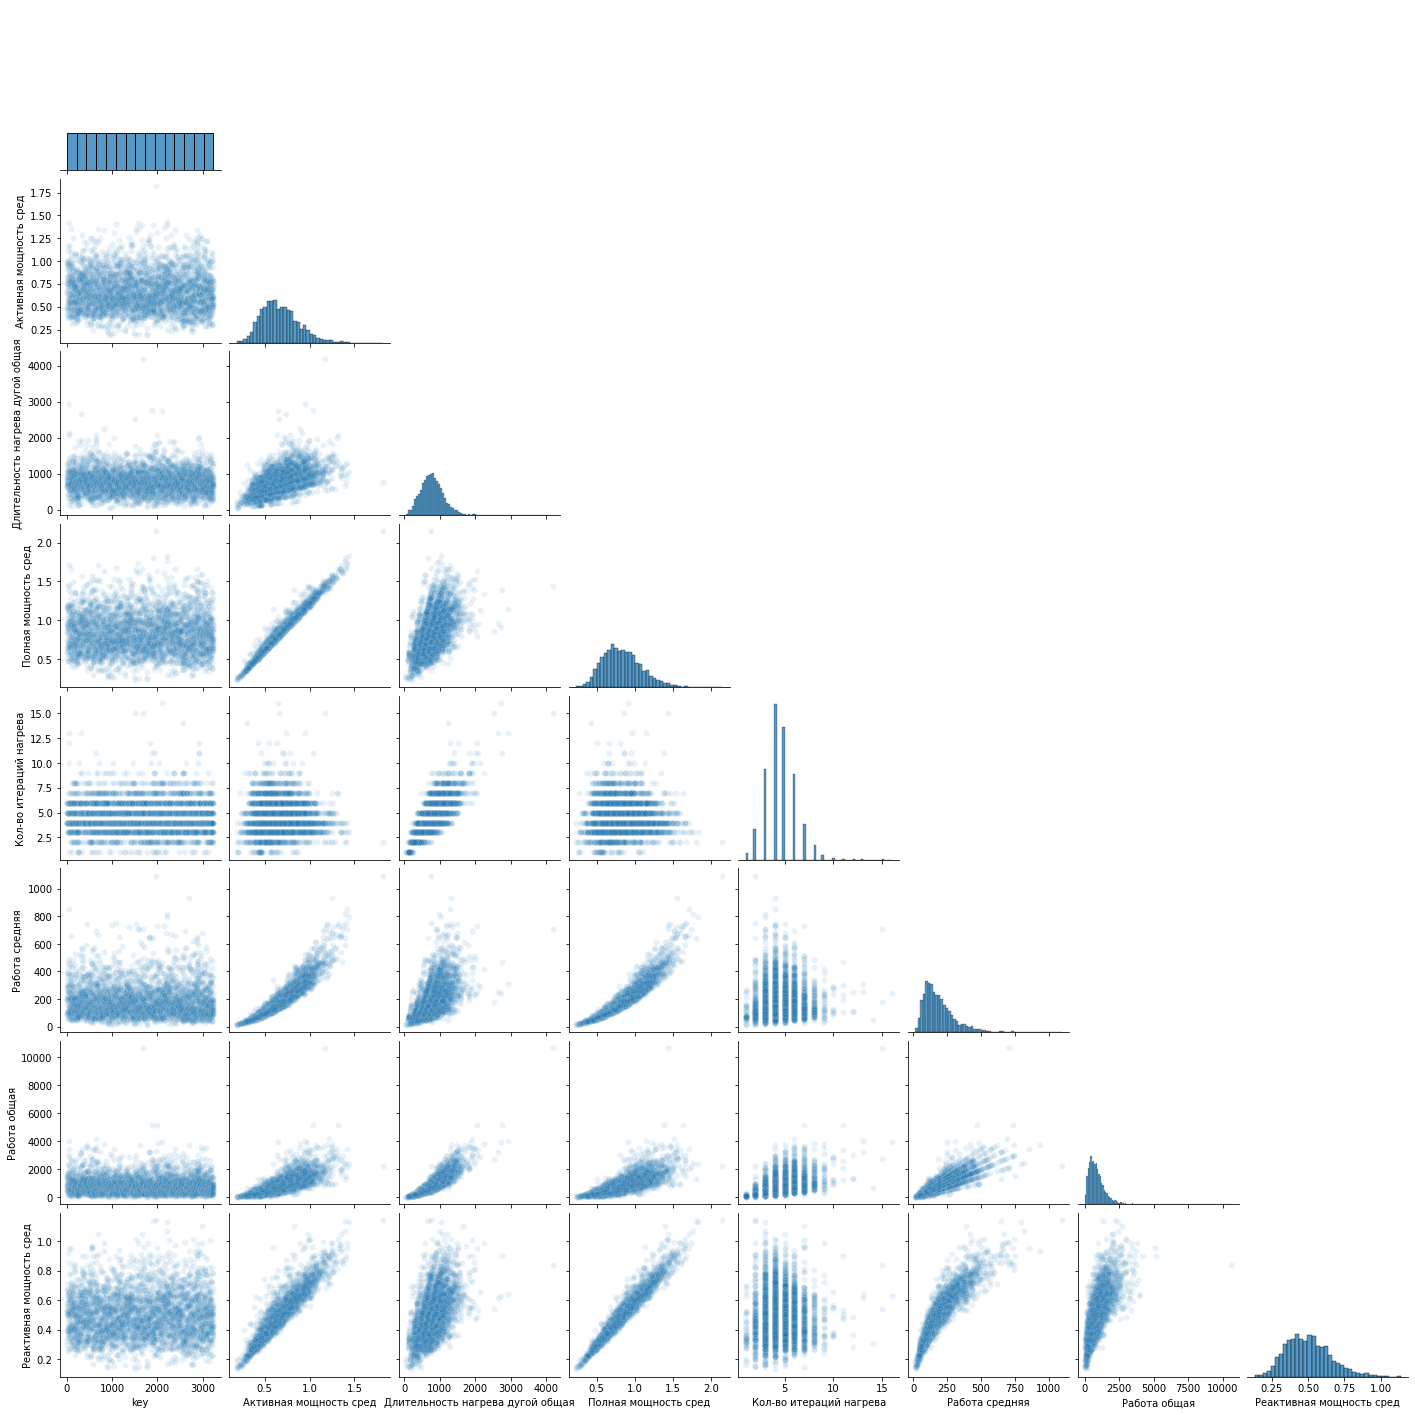

In [606]:
sns.pairplot(data_arc_pivot[data_arc_pivot['Реактивная мощность сред'] > -5], corner=True, plot_kws={'alpha': 0.1});

Видно, что много признаков коррелируют между собой, что логично? так как некоторые напрямую связаны между собой

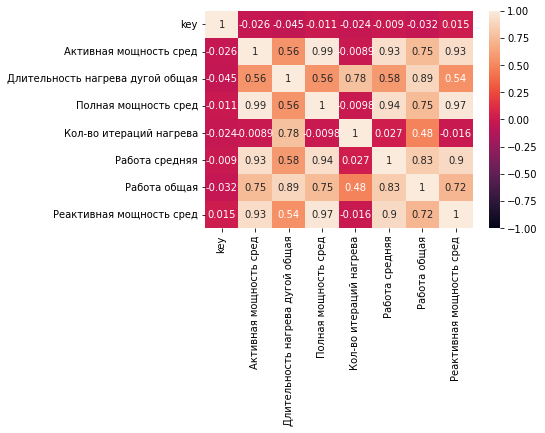

In [607]:
sns.heatmap(data_arc_pivot[data_arc_pivot['Реактивная мощность сред'] > -5].corr(), vmax=1, vmin=-1, annot=True);

Видно, что обе мощности (активная и реактивная) практически линейно коррелируют между собой, есть определнный разброс, но коэффициенты корреляции Пирсона близки к единице. Это логично, они производные от одной величины - обшей мощности - которую мы восстановили как доп. признак.

Что еще интересно, так это что время нагрева заметно коррелирует со средними мощностями - т.е. мы тратим мощности больше, при этом греем дольше - затраты энергии растут. Это странно, интуитивно должно быть наоборот: больше мощность - тратим меньше времени на подогрев.

Логично растет затраченная работа и время нагрева при увеличении итераций нагрева. Больше итераций, дольше суммарно греем, больше энергии при этом затрачиваем.

## Сыпучие материалы (объем)

In [608]:
try:
    data_bulk = pd.read_csv('data_bulk.csv')
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
display(data_bulk.head())
print()
print(data_bulk.info())
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Сразу можно отметить, что пропуски в данном датасете - означают, что данная добавка при производстве данной партии не применялась, т.е. ее объем равен нулю. Это будет важно при заполнении пропусков.

Создадим два новых признака: суммарный объем сыпучих материалов, примененных при выплавке партии и кол-во типов сыпучих материалов примененных при выплавке каждой партии.

In [609]:
data_bulk['sum'] = data_bulk.loc[:, 'Bulk 1' : 'Bulk 15'].sum(axis=1)

In [610]:
data_bulk['count'] = data_bulk.loc[:, 'Bulk 1' : 'Bulk 15'].count(axis=1)

Изучим на диаграммах рассеяния как по партиям рапспределены добавки.

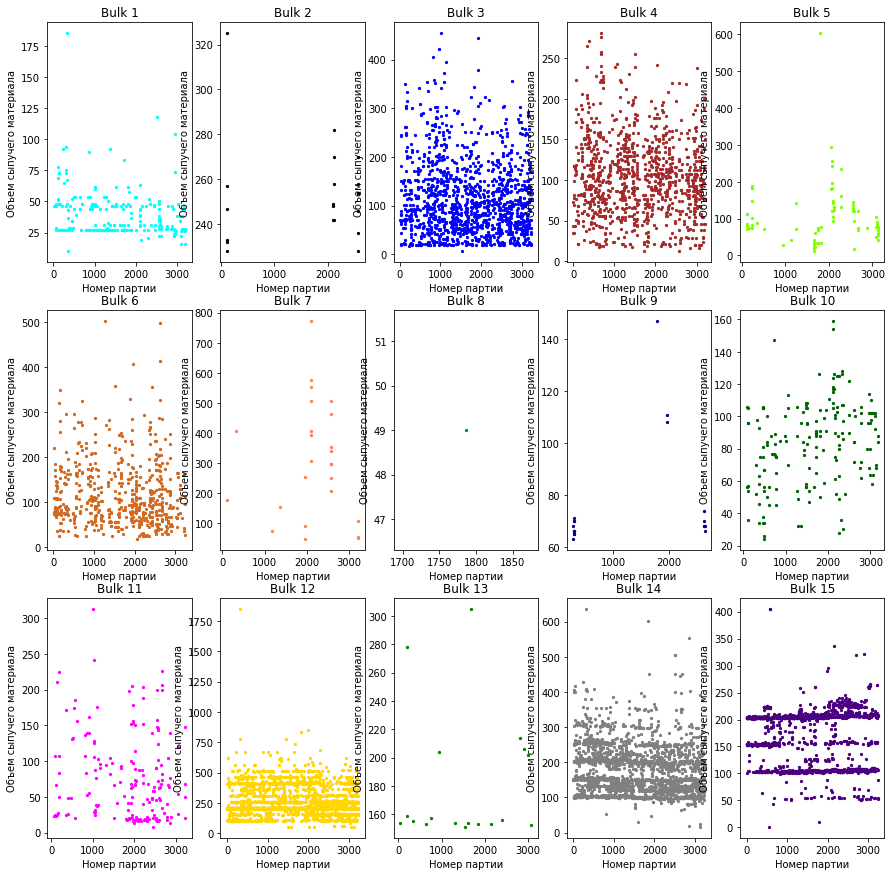

In [611]:
bulks = list(data_bulk.loc[:, 'Bulk 1' : 'Bulk 15'].columns)

fig, ((ax0, ax1, ax2, ax3, ax4), 
      (ax5, ax6, ax7, ax8, ax9), 
      (ax10, ax11, ax12, ax13, ax14)) = plt.subplots(nrows=3, ncols=5, figsize=(15, 15))

plots = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14]

for i in range(len(plots)):
    scatter = plots[i].scatter(data=data_bulk, 
                               x='key', 
                               y=bulks[i],
                               s=5,
                               c=colors_list[i]
                              )
    plots[i].set_title(bulks[i])
    plots[i].set_xlabel('Номер партии')
    plots[i].set_ylabel('Объем сыпучего материала')
plt.show()

Видно, что какие-то добавки используются постоянно (Bulk 1, Bulk 3, Bulk 4, Bulk6, Bulk12, Bulk 14, Bulk 15), есть добавки, которые используют редко и почти всегда в одинаковом объеме (Bulk 13), а есть добавки, которые используют редко при выпуске небольшого числа партий подряд (Bulk 2, Bulk 5, Bulk 9) - возможно в эти периоды использовалось какое-то отличное от большинства случаев сырье, более загрязненное например или с нетипичными примесями.

А вот например добавление материала из Bulk 1, Bulk12, Bulk14, Bulk 15 больше всего похоже на стабильный технологический процесс - четко видны горизонтальные группы точек - объемы, которые чаще всего добавляют - и тянутся линии вдоль всех партий - важный компонент технологического процесса, требуется постоянно.

Изучим наиболее насыщенные столбцы при помощи pairplot

Найдем непустые столбцы, примем непустым тот, в котором пропусков не более 90 процентов, т.е. как минимум 10 процентов партий использовали данную добавку.

In [612]:
non_null_bulks = []
for bulk in bulks:
    if data_bulk[bulk].isna().sum()/data_bulk.shape[0] <= 0.9:
        non_null_bulks.append(bulk)
non_null_bulks

['Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']

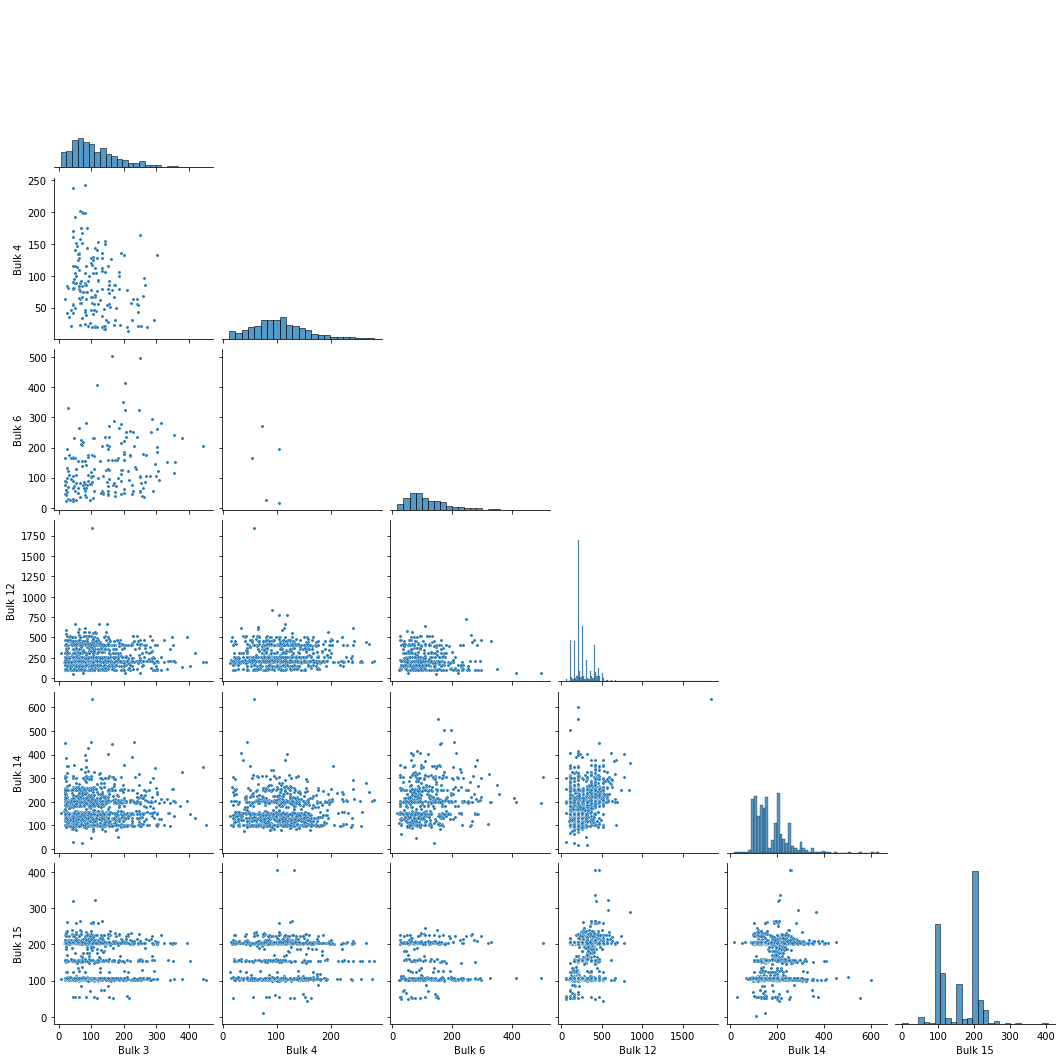

In [613]:
sns.pairplot(data_bulk[non_null_bulks], corner=True, plot_kws={'s':10});

Видно, что объемы часто применяемых сыпучих материалов не коррелируют между собой.

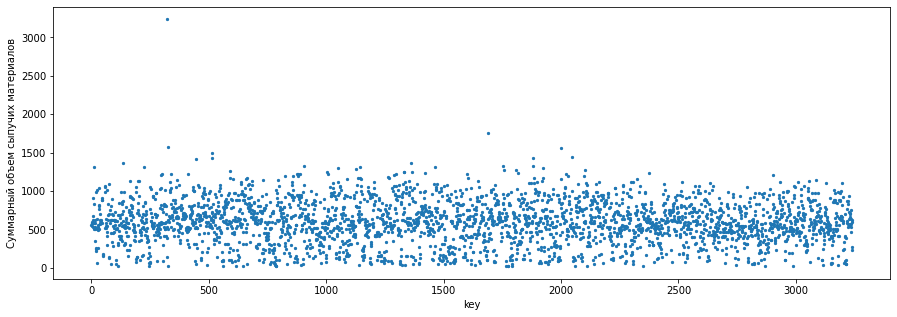

In [614]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))
ax.scatter(data=data_bulk,
           x='key',
           y='sum',
           s=5
          )
ax.set_xlabel('key')
ax.set_ylabel('Суммарный объем сыпучих материалов')
plt.show()

Видно что объем примесей, который требуется для процесса стабильно держится в пределах от 0 до 1500

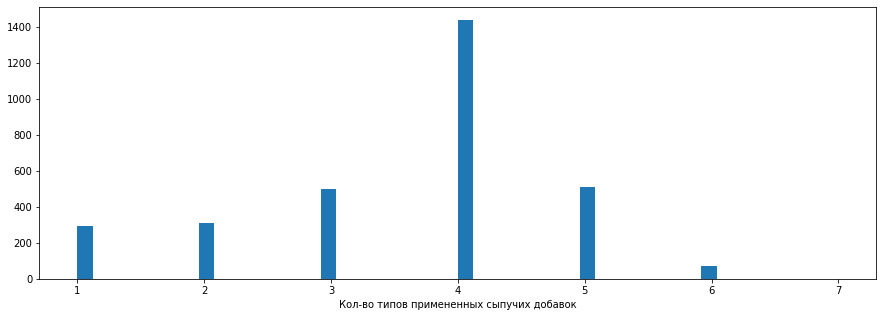

In [615]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

ax.hist(data=data_bulk,
        x='count',
        bins=50
       )
ax.set_xlabel('Кол-во типов примененных сыпучих добавок')
plt.show()

Видно, что чаще всего в технологическом процессе применяют 4 типа сыпучих материалов. В данных четко видно, что 6 типов примесей применяют достаточно редко, и есть совсем малое количество партий, к которых применили целых 7 типов сыпучих материалов.

## Сыпучие материалы (время)

In [616]:
try:
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
display(data_bulk_time.head())
print()
print(data_bulk_time.info())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


Так как есть информация от заказчика, что фиксация времени не синхронизирована между разными датасетами, данный датасет использовать довольно сложно.

## Газ

In [617]:
try:
    data_gas = pd.read_csv('data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
display(data_gas.head())
print()
print(data_gas.info())
data_gas.describe()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


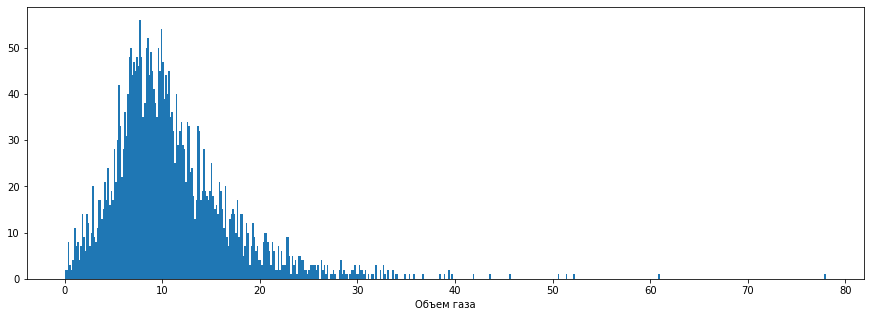

In [618]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

ax.hist(data=data_gas,
        x='Газ 1',
        bins=500
       )
ax.set_xlabel('Объем газа')
plt.show()

Видно, что в основном для производства не требуется более 30 (единиц объема) газа

## Температура

In [619]:
try:
    data_temp = pd.read_csv('data_temp.csv')
except:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
display(data_temp.head(10))
print()
print(data_temp.info())
data_temp.describe()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Сразу исключим разрешенные аномалии (заодно создадим список аномальных партий):

In [620]:
anomaly_temp = list(data_temp[data_temp['Температура'] < 1500]['key'])
data_temp = data_temp.query('key not in @anomaly_temp')

In [621]:
data_temp_pivot = data_temp.fillna(0)

Оставим только первые и последние температуры нагрва

In [622]:
data_temp_pivot = data_temp_pivot.pivot_table(index='key', values='Температура', aggfunc=['first', 'last']).reset_index()
data_temp_pivot.columns = ['_'.join(col) for col in data_temp_pivot.columns]
data_temp_pivot.columns = ['key', 'first_temp', 'last_temp']
data_temp_pivot

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
3205,3237,1569.0,0.0
3206,3238,1584.0,0.0
3207,3239,1598.0,0.0
3208,3240,1617.0,0.0


Отбросим те пратии, где последняя температура равная 0 (по сути является пропуском) и при предсказании эти партии будут мешать работе модели

In [623]:
data_temp_pivot = data_temp_pivot[data_temp_pivot['last_temp'] != 0]
data_temp_pivot = data_temp_pivot[data_temp_pivot['first_temp'] != 0]

In [624]:
data_temp_pivot

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2467,2495,1570.0,1591.0
2468,2496,1554.0,1591.0
2469,2497,1571.0,1589.0
2470,2498,1591.0,1594.0


In [625]:
data_temp_pivot.describe()

,key,first_temp,last_temp
count,2472.000000,2472.000000,2472.000000
mean,1249.434466,1589.000809,1595.307443
std,720.450668,24.989500,15.962197
min,1.000000,1519.000000,1541.000000
25%,626.750000,1572.000000,1587.000000
50%,1250.500000,1588.000000,1593.000000
75%,1872.250000,1605.000000,1599.000000
max,2499.000000,1679.000000,1700.000000


Медианные и средние температуры очень близки,значит больших скоплений аномальных значений нет.

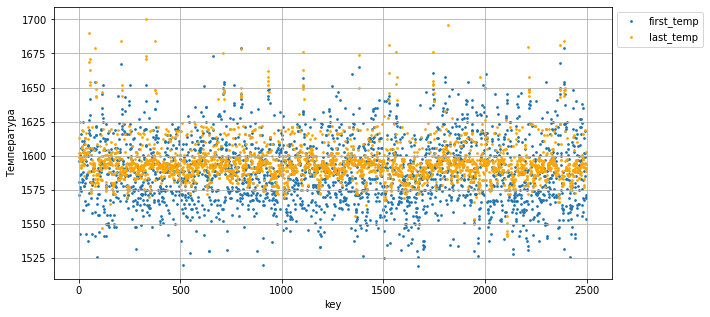

In [626]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax.scatter(data=data_temp_pivot,
           x='key',
           y='first_temp',
           s=3
          )
ax.scatter(data=data_temp_pivot,
           x='key',
           y='last_temp',
           s=3,
           c='orange'
          )
ax.set_xlabel('key')
ax.set_ylabel('Tемпература')
ax.grid(True)
ax.legend(['first_temp', 'last_temp'], bbox_to_anchor=(1, 1))
plt.show()

Аномалий дейстивтельно не видно, есть группы партий, с высокими конечными температурами

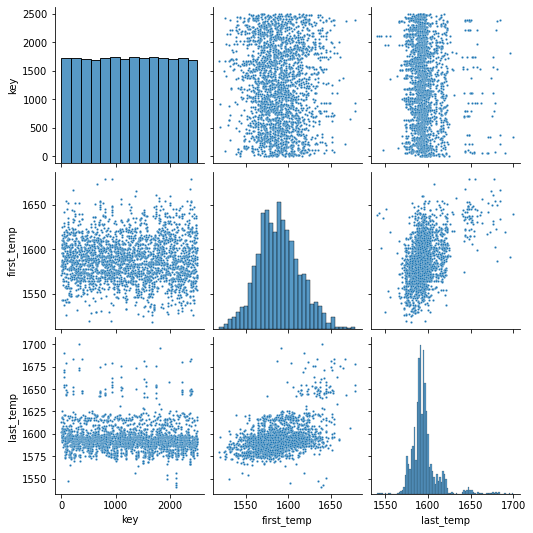

In [627]:
sns.pairplot(data_temp_pivot, plot_kws={"s" : 5});

На графиах разброса между первой и второй температурой четко видно отделившуюся группу точек с более высокими конечными температурами. Это какие-то нетипичные процессы разбросанные по всему периоду измерений

In [628]:
data_temp_pivot.corr()

,key,first_temp,last_temp
key,1.000000,-0.015514,-0.082606
first_temp,-0.015514,1.000000,0.436783
last_temp,-0.082606,0.436783,1.000000


Видно, что темепературы не коррелируют между собой или с номерами партий

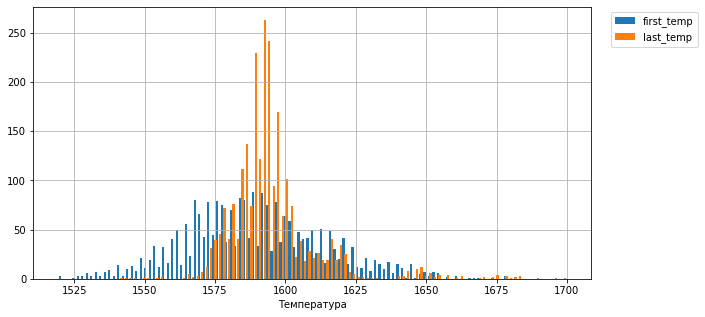

In [629]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax.hist(data=data_temp_pivot,
        x='first_temp',
        bins=100, 
        rwidth=0.5
       )
ax.hist(data=data_temp_pivot,
        x='last_temp',
        bins=100,
        rwidth=0.5
       )
ax.set_xlabel('Tемпература')
ax.grid(True)
ax.legend(['first_temp', 'last_temp'], bbox_to_anchor=(1.2, 1))
plt.show()

Конечные температуры имеют гораздо меньший разброс, также заметна та самая группа высоких конечных температур.

## Проволока (объем)

In [630]:
try:
    data_wire = pd.read_csv('data_wire.csv')
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
display(data_wire.head())
print()
print(data_wire.info())
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Пропуски в дананом датасете также означают, что проволока не использовалась при производстве данной партии

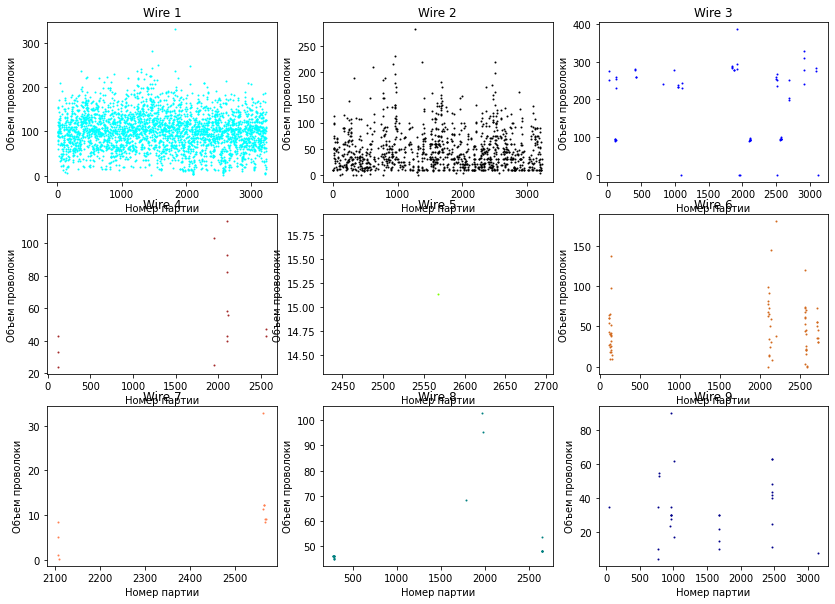

In [631]:
wires = list(data_wire.loc[:, 'Wire 1' : 'Wire 9'].columns)

fig, ((ax0, ax1, ax2,), 
      (ax3, ax4, ax5,), 
      (ax6, ax7, ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))

plots = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(len(plots)):
    scatter = plots[i].scatter(data=data_wire, 
                               x='key', 
                               y=wires[i],
                               s=1,
                               c=colors_list[i]
                              )
    plots[i].set_title(wires[i])
    plots[i].set_xlabel('Номер партии')
    plots[i].set_ylabel('Объем проволоки')
plt.show()

Ситуация аналогичная сыпучим материалам. Какая-то проволока используется при производстве любой или практически любой партии, а какая-то требуется только в определнные моменты для выпуска нескольких последовательных партий. Сохраняю свою предположение, что эти партии выпускаются из сырья с какими-то специфичными отличиями в составе, по сравнению со стандартным (наиболее частым) составом сырья.

Изучим столбцы, где пропусков не более 90 процентов.

In [632]:
non_null_wires = []
for wire in wires:
    if data_wire[wire].isna().sum()/data_wire.shape[0] <= 0.90:
        non_null_wires.append(wire)
non_null_wires

['Wire 1', 'Wire 2']

Самый популярные проволоки - это Wire 1 и Wire 2

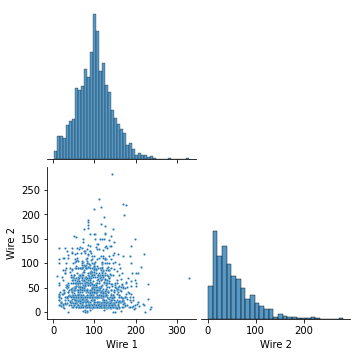

In [633]:
sns.pairplot(data_wire[non_null_wires], corner=True, plot_kws={'s':5});

Видно что Wire 1 и Wire 2 между собой не коррелируют

Добавим новые признаки: общий объем проволоки и количество типов примененной проволоки

In [634]:
data_wire['sum'] = data_wire.loc[:, 'Wire 1' : 'Wire 9'].sum(axis=1)
data_wire['count'] = data_wire.loc[:, 'Wire 1' : 'Wire 9'].count(axis=1)

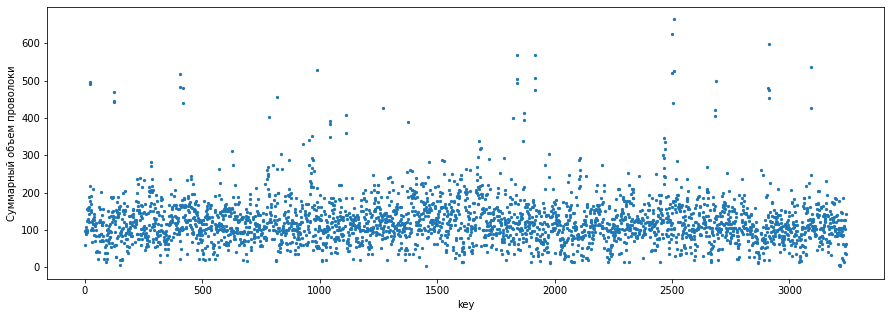

In [635]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))
ax.scatter(data=data_wire,
           x='key',
           y='sum',
           s=5
          )
ax.set_xlabel('key')
ax.set_ylabel('Суммарный объем проволоки')
plt.show()

Видно что есть определнный коридор значений объема проволоки. Можно заметить наличие партий, для которых объем проволоки сильно выбивается из коридора. Эти партии собраны в вертикальные группы - вероятно несколько партий подряд из одного и того-же нетипичного сырья.

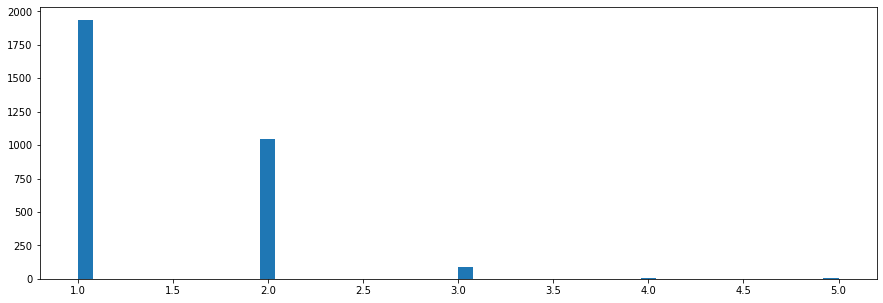

In [636]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

ax.hist(data=data_wire,
        x='count',
        bins=50
       )
plt.show()

Видно, что чаще всего применяют 1 или 2 типа проволоки, больше - уже редкость.

## Проволока (время)

In [637]:
try:
    data_wire_time = pd.read_csv('data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
display(data_wire_time.head())
print()
print(data_wire_time.info())
data_wire_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Так как есть информация от заказчика, что фиксация времени не синхронизирована между разными датасетами, данный датасет использовать довольно сложно.

<a id='plan'></a>

# ПЛАН



- [ ] Провести предобработку данных (убрать аномалии, ненужные признаки, заполнить пропуски). В итоге должен склеить все датасеты и получить общий датасет со всеми важными на мой взгляд признаками и таргетом
- [ ] Выделить таргет. Разбить готовый предобработанный датасет на выборки (трейн и тест)
- [ ] Выбрать несколько моделей: стандартные линейная регрессия, дерево + CatBoost и LightGBM.
- [ ] Bayes Search - ищем лучшие параметры, обучаем модель, получаем метрику MAE. Повторяем для каждой модели.
- [ ] Выбрав лучшую модель проверяем ее на тестовой выборке. Получаем наш результат
- [ ] Отчет о проделанной работе, результатах, может быть какие-то рекомендации для заказчика.

[Обратно к отчету](#report)

# Предобработка данных

## Электроды

Датасет с новыми фичами

In [638]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагрева дугой,Полная мощность,Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,0.807239,119.471318


Посторим матрицу корреляций

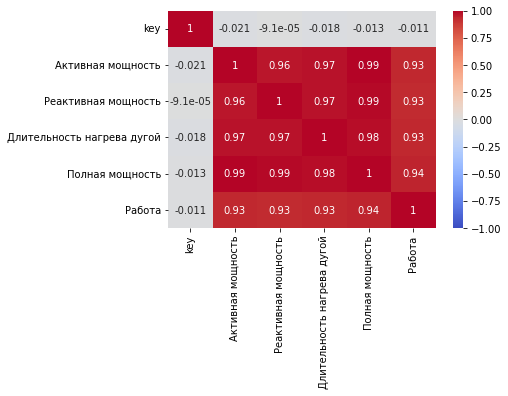

In [639]:
plt.figure(figsize=(6, 4))
sns.heatmap(data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой'], axis=1).corr(), 
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='coolwarm');

In [640]:
data_arc_pretrain = data_arc.copy()

Отбросим данные о времени начала и конца нагрева.

In [641]:
data_arc_pretrain = data_arc_pretrain.drop(['Начало нагрева дугой', 
                                            'Конец нагрева дугой'
                                           ], axis=1)

In [642]:
data_arc_pretrain.head()

,key,Активная мощность,Реактивная мощность,Длительность нагрева дугой,Полная мощность,Работа
0,1,0.976059,0.687084,228.0,1.193639,272.149755
1,1,0.805607,0.520285,185.0,0.959010,177.416785
2,1,0.744363,0.498805,172.0,0.896038,154.118502
3,1,1.659363,1.062669,365.0,1.970470,719.221394
4,1,0.692755,0.414397,148.0,0.807239,119.471318


In [643]:
data_arc_pretrain.columns = ['key', 'active_power', 'reactive_power', 'heat_duration', 'power', 'energy']
data_arc_pretrain.head()

,key,active_power,reactive_power,heat_duration,power,energy
0,1,0.976059,0.687084,228.0,1.193639,272.149755
1,1,0.805607,0.520285,185.0,0.959010,177.416785
2,1,0.744363,0.498805,172.0,0.896038,154.118502
3,1,1.659363,1.062669,365.0,1.970470,719.221394
4,1,0.692755,0.414397,148.0,0.807239,119.471318


Проагрегируем по номеру партии. Мощность будет средняя, а время нагрева будем суммировать

In [644]:
data_arc_pretrain = data_arc_pretrain.pivot_table(values=['heat_duration', 
                                                          'power', 
                                                          'active_power',
                                                          'reactive_power',
                                                          'energy'
                                                         ], 
                                                  index='key', 
                                                  aggfunc={'heat_duration' : 'sum',
                                                           'power' : ['mean', 'count'],
                                                           'energy' : 'sum',
                                                           'active_power' : 'mean',
                                                           'reactive_power' : 'mean'
                                                          })
data_arc_pretrain = data_arc_pretrain.reset_index()
data_arc_pretrain.columns = [''.join(col) for col in data_arc_pretrain.columns]
data_arc_pretrain = data_arc_pretrain.rename({'heat_durationsum' : 'heat_duration_total',
                                              'powercount' : 'count_iterations',
                                              'powermean' : 'power_mean',
                                              'energysum' : 'energy_total',
                                              'active_powermean' : 'active_power_mean',
                                              'reactive_powermean' : 'reactive_power_mean'
                                             }, axis=1)
data_arc_pretrain.head()

,key,active_power_mean,energy_total,heat_duration_total,count_iterations,power_mean,reactive_power_mean
0,1,0.975629,1442.377754,1098.0,5,1.165279,0.636648
1,2,0.763150,881.233565,811.0,4,0.912304,0.499528
2,3,0.505176,525.066777,655.0,5,0.597907,0.319815
3,4,0.802313,796.911309,741.0,4,0.953741,0.515074
4,5,0.836793,1199.137958,869.0,4,1.008939,0.563161


## Сыпучие материалы

In [645]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum,count
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0,4
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0,4
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0,4
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0,4
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0,4


Заполним все пропуски нулями - это эквивалентно нулевому объему примененной примеси

In [646]:
data_bulk_pretrain = data_bulk.fillna(0)
data_bulk_pretrain = data_bulk_pretrain.rename(columns={'sum' : 'sum_bulk', 'count' : 'count_bulk'})
data_bulk_pretrain.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk,count_bulk
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,553.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,582.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,544.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,595.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,584.0,4


In [647]:
zero_bulks = []
for i in range(len(bulks)):
    try:
        if data_bulk_pretrain[bulks[i]].value_counts()[0] / len(data_bulk_pretrain) > 0.99:
            print('Доля нулевых значений в столбце', 
                  bulks[i], ':', data_bulk_pretrain[bulks[i]].value_counts()[0] / len(data_bulk_pretrain), '++++')
            zero_bulks.append(bulks[i])
        else:
            print('Доля нулевых значений в столбце', 
                  bulks[i], ':', data_bulk_pretrain[bulks[i]].value_counts()[0] / len(data_bulk_pretrain))
    except:
        print('Нулевых значений в', bulks[i], 'нет')
    print()


Доля нулевых значений в столбце Bulk 1 : 0.9194630872483222

Доля нулевых значений в столбце Bulk 2 : 0.9929689996804091 ++++

Доля нулевых значений в столбце Bulk 3 : 0.5851709811441355

Доля нулевых значений в столбце Bulk 4 : 0.675934803451582

Доля нулевых значений в столбце Bulk 5 : 0.9753914988814317

Доля нулевых значений в столбце Bulk 6 : 0.8159156279961649

Доля нулевых значений в столбце Bulk 7 : 0.9920102269095558 ++++

Доля нулевых значений в столбце Bulk 8 : 0.9996804090763822 ++++

Доля нулевых значений в столбце Bulk 9 : 0.9939277724512624 ++++

Доля нулевых значений в столбце Bulk 10 : 0.9437519974432726

Доля нулевых значений в столбце Bulk 11 : 0.9434324065196549

Доля нулевых значений в столбце Bulk 12 : 0.21700223713646533

Доля нулевых значений в столбце Bulk 13 : 0.9942473633748802 ++++

Доля нулевых значений в столбце Bulk 14 : 0.10322786832853947

Доля нулевых значений в столбце Bulk 15 : 0.2815596037072547



Видно, что 5 столбцах более 99 процентов строк заполнены нулями. Такие признаки полезными вряд ли будут. Отбросим их.

In [648]:
data_bulk_pretrain = data_bulk_pretrain.drop(zero_bulks, axis=1, errors='ignore')

## Газ

In [649]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [650]:
data_gas_pretrain = data_gas.copy()
data_gas_pretrain.columns = ['key', 'gas']

In [651]:
data_gas_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет

## Температура

In [652]:
data_temp_pivot.head()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [653]:
data_temp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2472 entries, 0 to 2471
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2472 non-null   int64  
 1   first_temp  2472 non-null   float64
 2   last_temp   2472 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 141.8 KB


In [654]:
data_temp_pretrain = data_temp_pivot.copy()

## Проволока

In [655]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum,count
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,1
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,1
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,1
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515,1
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.088959,1
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.128799,1
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.357761,1
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.070400,1


In [656]:
data_wire_pretrain = data_wire.fillna(0)
data_wire_pretrain = data_wire_pretrain.rename(columns={'sum' : 'sum_wire', 'count' : 'count_wire'})
data_wire_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3081 non-null   int64  
 1   Wire 1      3081 non-null   float64
 2   Wire 2      3081 non-null   float64
 3   Wire 3      3081 non-null   float64
 4   Wire 4      3081 non-null   float64
 5   Wire 5      3081 non-null   float64
 6   Wire 6      3081 non-null   float64
 7   Wire 7      3081 non-null   float64
 8   Wire 8      3081 non-null   float64
 9   Wire 9      3081 non-null   float64
 10  sum_wire    3081 non-null   float64
 11  count_wire  3081 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 289.0 KB


In [657]:
zero_wires = []
for i in range(len(wires)):
    try:
        if data_wire_pretrain[wires[i]].value_counts()[0] / len(data_wire_pretrain) > 0.99:
            print('Доля нулевых значений в столбце', 
                  wires[i], ':', data_wire_pretrain[wires[i]].value_counts()[0] / len(data_wire_pretrain), '++++')
            zero_wires.append(wires[i])
        else:
            print('Доля нулевых значений в столбце', 
                  wires[i], ':', data_wire_pretrain[wires[i]].value_counts()[0] / len(data_wire_pretrain))
    except:
        print('Нулевых значений в', wires[i], 'нет')
    print()

Доля нулевых значений в столбце Wire 1 : 0.008438818565400843

Доля нулевых значений в столбце Wire 2 : 0.6497890295358649

Доля нулевых значений в столбце Wire 3 : 0.9795520934761441

Доля нулевых значений в столбце Wire 4 : 0.9954560207724765 ++++

Доля нулевых значений в столбце Wire 5 : 0.9996754300551769 ++++

Доля нулевых значений в столбце Wire 6 : 0.976306394027913

Доля нулевых значений в столбце Wire 7 : 0.9964297306069458 ++++

Доля нулевых значений в столбце Wire 8 : 0.9938331710483609 ++++

Доля нулевых значений в столбце Wire 9 : 0.9905874716001298 ++++



Видно, что 5 признаков на 99 процентов заплонены нулями, при обучении они бесполезныи даже вредны.

In [658]:
data_wire_pretrain = data_wire_pretrain.drop(zero_wires, axis=1, errors='ignore')

## Общий датасет

Объединеним все наши датасеты в единый датасет по ключу

In [659]:
data = data_arc_pretrain.set_index('key').join(data_bulk_pretrain.set_index('key'), how='inner')
data = data.join(data_gas_pretrain.set_index('key'), how='inner')
data = data.join(data_temp_pretrain.set_index('key'), how='inner')
data = data.join(data_wire_pretrain.set_index('key'), how='inner')
data = data.reset_index(drop=True)
data.head()

,active_power_mean,energy_total,heat_duration_total,count_iterations,power_mean,reactive_power_mean,Bulk 1,Bulk 3,Bulk 4,Bulk 5,...,count_bulk,gas,first_temp,last_temp,Wire 1,Wire 2,Wire 3,Wire 6,sum_wire,count_wire
0,0.975629,1442.377754,1098.0,5,1.165279,0.636648,0.0,0.0,43.0,0.0,...,4,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.0,60.059998,1
1,0.763150,881.233565,811.0,4,0.912304,0.499528,0.0,0.0,73.0,0.0,...,4,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.0,96.052315,1
2,0.505176,525.066777,655.0,5,0.597907,0.319815,0.0,0.0,34.0,0.0,...,4,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.0,91.160157,1
3,0.802313,796.911309,741.0,4,0.953741,0.515074,0.0,0.0,81.0,0.0,...,4,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.0,89.063515,1
4,0.836793,1199.137958,869.0,4,1.008939,0.563161,0.0,0.0,78.0,0.0,...,4,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.0,98.352796,2


In [660]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   active_power_mean    2324 non-null   float64
 1   energy_total         2324 non-null   float64
 2   heat_duration_total  2324 non-null   float64
 3   count_iterations     2324 non-null   int64  
 4   power_mean           2324 non-null   float64
 5   reactive_power_mean  2324 non-null   float64
 6   Bulk 1               2324 non-null   float64
 7   Bulk 3               2324 non-null   float64
 8   Bulk 4               2324 non-null   float64
 9   Bulk 5               2324 non-null   float64
 10  Bulk 6               2324 non-null   float64
 11  Bulk 10              2324 non-null   float64
 12  Bulk 11              2324 non-null   float64
 13  Bulk 12              2324 non-null   float64
 14  Bulk 14              2324 non-null   float64
 15  Bulk 15              2324 non-null   f

## Train Test Split

In [661]:
data_train, data_test = train_test_split(data,
                                         test_size=0.25,
                                         random_state=110423)
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

## Поиск аномалий в треноровочной выборке

In [662]:
def histogram(data, x, xlabel=None, bins=100, figsize=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(data=data, x=x, bins=bins)
    if xlabel == None:
        ax.set_xlabel(x)
    else:
        ax.set_xlabel(xlabel)
    plt.show()

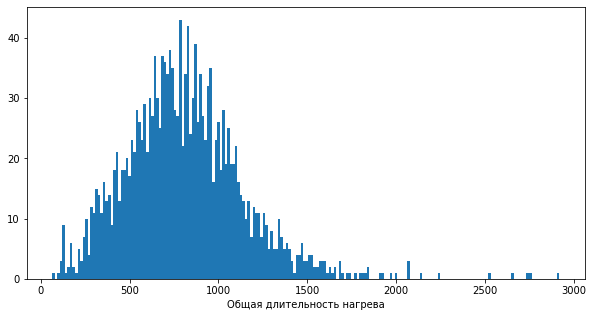

In [663]:
histogram(data_train, 'heat_duration_total', 'Общая длительность нагрева', 200)

Отбросим измерения, в которых время нагрева было более 2000 секунд

In [664]:
data_train = data_train[data_train['heat_duration_total'] <= 2000]

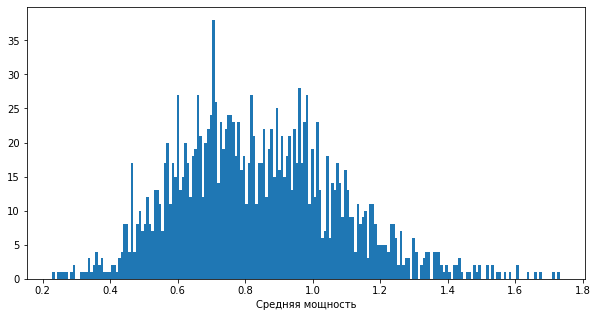

In [665]:
histogram(data_train, 'power_mean', 'Средняя мощность', 200)

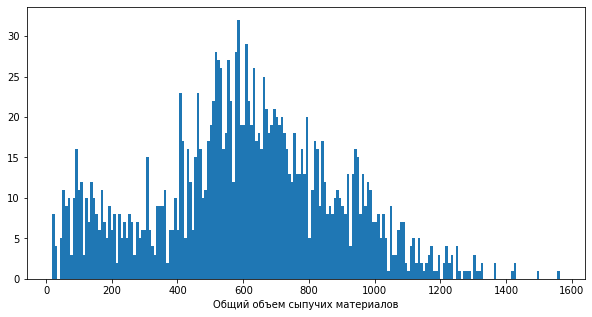

In [666]:
histogram(data_train, 'sum_bulk', 'Общий объем сыпучих материалов', 200)

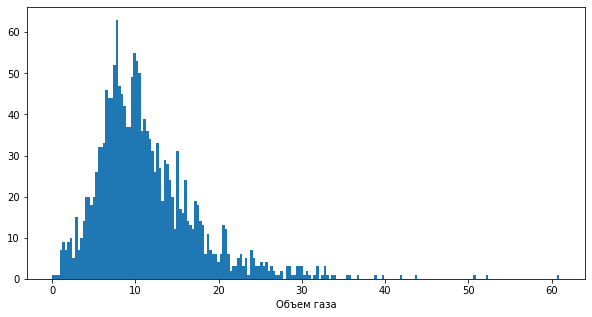

In [667]:
histogram(data_train, 'gas', 'Объем газа', 200)

Отбросим измерения, где газа применялось более 30 единиц объема

In [668]:
data_train = data_train[data_train['gas'] <= 30]

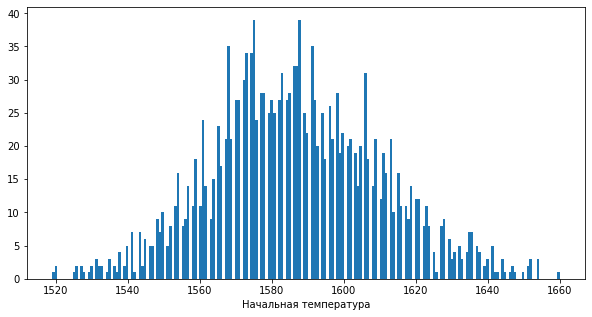

In [669]:
histogram(data_train, 'first_temp', 'Начальная температура', 200)

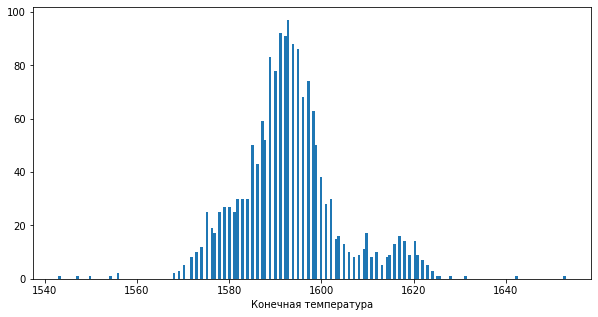

In [670]:
histogram(data_train, 'last_temp', 'Конечная температура', 200)

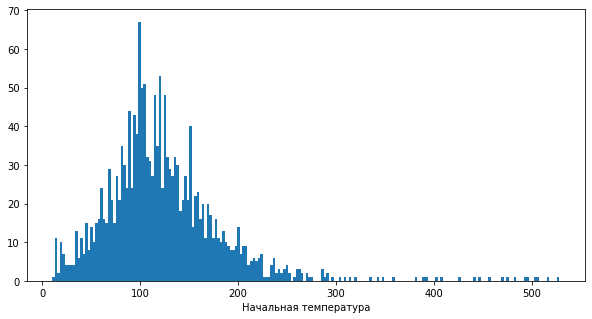

In [671]:
histogram(data_train, 'sum_wire', 'Начальная температура', 200)

Отбросим измерения, где проволоки применялось более 300 единиц объема.

In [672]:
data_train = data_train[data_train['sum_wire'] <= 300]

Видно, что есть 6 столбцов с проводами более чем на 99 процентов заполненных нулями. Удалим эти столбцы, так как они выглядят бесполезными для обучения модели.

In [673]:
data_train = data_train.astype(float)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1680 entries, 0 to 1742
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   active_power_mean    1680 non-null   float64
 1   energy_total         1680 non-null   float64
 2   heat_duration_total  1680 non-null   float64
 3   count_iterations     1680 non-null   float64
 4   power_mean           1680 non-null   float64
 5   reactive_power_mean  1680 non-null   float64
 6   Bulk 1               1680 non-null   float64
 7   Bulk 3               1680 non-null   float64
 8   Bulk 4               1680 non-null   float64
 9   Bulk 5               1680 non-null   float64
 10  Bulk 6               1680 non-null   float64
 11  Bulk 10              1680 non-null   float64
 12  Bulk 11              1680 non-null   float64
 13  Bulk 12              1680 non-null   float64
 14  Bulk 14              1680 non-null   float64
 15  Bulk 15              1680 non-null   f

In [674]:
data_test = data_test.astype(float)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581 entries, 0 to 580
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   active_power_mean    581 non-null    float64
 1   energy_total         581 non-null    float64
 2   heat_duration_total  581 non-null    float64
 3   count_iterations     581 non-null    float64
 4   power_mean           581 non-null    float64
 5   reactive_power_mean  581 non-null    float64
 6   Bulk 1               581 non-null    float64
 7   Bulk 3               581 non-null    float64
 8   Bulk 4               581 non-null    float64
 9   Bulk 5               581 non-null    float64
 10  Bulk 6               581 non-null    float64
 11  Bulk 10              581 non-null    float64
 12  Bulk 11              581 non-null    float64
 13  Bulk 12              581 non-null    float64
 14  Bulk 14              581 non-null    float64
 15  Bulk 15              581 non-null    flo

Пропусков нет, в наличие осталось 1680 измерений в тернировочной выборке и 581 в тестовой.

Выделим признаки и целевой признак

In [675]:
features_train = data_train.drop(['last_temp'], axis=1)
features_test = data_test.drop(['last_temp'], axis=1)
target_train = data_train['last_temp']
target_test = data_test['last_temp']

In [676]:
def search_best_params(model, 
                       params,
                       features,
                       target,
                       cv,
                       n_iter, 
                       scoring, 
                       random_state):
    clf = BayesSearchCV(model,
                        search_spaces=params,
                        scoring=scoring,
                        cv=cv,
                        n_jobs=-1,
                        n_iter=n_iter, 
                        random_state=random_state
                        )
    search = clf.fit(features, target)
    print()
    display('Лучшее значение MAE:', abs(search.best_score_))
    print()
    print('Лучшие гиперпараметры:', clf.best_params_)
    return clf.best_estimator_, abs(clf.best_score_)

def add_model(name,
              table,
              score,
              i
             ):
    new_row = pd.DataFrame(data=[[name, 
                                  score]], 
                            columns=list(table.columns))
    table.loc[i, :] = new_row.loc[0, :]
    display(models)
    return table

def cv_mae(model, cv, features, target):
    cv_results = cross_val_score(model, 
                                 features, 
                                 target, 
                                 cv=cv, 
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1)
    mae = abs(sum(cv_results) / len(cv_results))
    return mae

<a id='models'></a>

# Модели

In [677]:
models = pd.DataFrame(data=[[0, 0]], columns=['Name', 'Best_MAE'])
i = 0

<a id='const'></a>

## Константная модель

Для оценки адекватности 

In [678]:
const_pred = pd.Series(index=features_test.index, data=target_train.mean())

const_mae = mae(target_test, const_pred)
print('MAE:', const_mae)


MAE: 8.262030776165894


In [679]:
models = add_model('Constant model',
                   models,
                   const_mae,
                   i)
i += 1

,Name,Best_MAE
0,Constant model,8.262031


Так как наихудшим приемлемым результатом является значение MAE 6.8, то можем сказать, что константная модель не работает.

<a id='lin'></a>

## ElasticNet

In [680]:
transformer = StandardScaler().fit(features_train)
features_train_norm = transformer.transform(features_train)

In [681]:
lin_model = ElasticNet(random_state=RANDOM_STATE)

lin_params = {'l1_ratio' : Real(0.01, 1, METHOD),
              'max_iter' : Integer(100, 3000, METHOD)
             }

best_lin, best_score_lin = search_best_params(lin_model,
                                              lin_params,
                                              features_train_norm,
                                              target_train,
                                              CV,
                                              N_ITER,
                                              SCORING,
                                              RANDOM_STATE
                                             )

'Лучшее значение MAE:'

6.405180301696419


Лучшие гиперпараметры: OrderedDict([('l1_ratio', 0.7759111189516177), ('max_iter', 2965)])


In [682]:
models = add_model('Linear regression',
                   models,
                   best_score_lin,
                   i
                  )
i += 1

,Name,Best_MAE
0,Constant model,8.262031
1,Linear regression,6.405180


Линейная регрессия при кроссвалидации показала MAE лучше константного и попала в приемлимый диапазон значений метрики.

<a id='tree'></a>

## Дерево решений

In [683]:
tree_model = DecisionTreeRegressor(random_state=RANDOM_STATE)

tree_params = {'max_depth' : Integer(1, MAX_DEPTH, METHOD),
               'min_samples_leaf' : Integer(1, MIN_SAMPLES_LEAF, METHOD),
               'min_samples_split' : Integer(2, MIN_SAMPLES_SPLIT, METHOD)
              }

best_tree, best_score_tree = search_best_params(tree_model,
                                                tree_params,
                                                features_train,
                                                target_train,
                                                CV,
                                                N_ITER,
                                                SCORING,
                                                RANDOM_STATE
                                               )

'Лучшее значение MAE:'

7.00709027238108


Лучшие гиперпараметры: OrderedDict([('max_depth', 4), ('min_samples_leaf', 5), ('min_samples_split', 8)])


In [684]:
models = add_model('Decision tree regressor',
                   models,
                   best_score_tree,
                   i
                  )
i += 1

,Name,Best_MAE
0,Constant model,8.262031
1,Linear regression,6.405180
2,Decision tree regressor,7.007090


Уже лучше, но близко к линейной регресии и все еще далеко от хорошего результата

<a id='lgbm'></a>

## LightGBM

In [685]:
features_train = features_train.astype(dtype=np.dtype('float32'))

In [686]:
LGBM_model = LGBMRegressor(random_state=RANDOM_STATE, 
                           n_jobs=-1, 
                           deterministic=True, 
                           bagging_freq=1,
                           extra_trees=True
                          )

LGBM_params = {'max_depth' : Integer(1, MAX_DEPTH, METHOD),
               'n_estimators' : Integer(50, N_ESTIMATORS, METHOD),
               'min_data_in_leaf' : Integer(2, MIN_DATA_IN_LEAF, METHOD),
              }

best_LGBM, best_score_LGBM = search_best_params(LGBM_model,
                                                params=LGBM_params,
                                                features=features_train,
                                                target=target_train,
                                                cv=CV,
                                                n_iter=N_ITER,
                                                scoring=SCORING,
                                                random_state=RANDOM_STATE
                                               )

[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1



'Лучшее значение MAE:'

5.820221299435032


Лучшие гиперпараметры: OrderedDict([('max_depth', 4), ('min_data_in_leaf', 8), ('n_estimators', 201)])


In [687]:
models = add_model('LGBM_regressor',
                   models,
                   best_score_LGBM,
                   i
                  )
i += 1

,Name,Best_MAE
0,Constant model,8.262031
1,Linear regression,6.405180
2,Decision tree regressor,7.007090
3,LGBM_regressor,5.820221


Сразу получили MAE ниже 6 - целевое значение.

<a id='CB'></a>

## CatBoost

In [688]:
CB_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=100)

CB_params = {'iterations' : Integer(50, N_ESTIMATORS, METHOD),
             'depth' : Integer(1, MAX_DEPTH, METHOD),
             'max_bin' : Integer(10, 200, METHOD)
            }

best_CB, best_score_CB = search_best_params(CB_model,
                                            params=CB_params,
                                            features=features_train,
                                            target=target_train,
                                            cv=CV,
                                            n_iter=N_ITER,
                                            scoring=SCORING,
                                            random_state=RANDOM_STATE)

Learning rate set to 0.219774
0:	learn: 10.5645911	total: 1.33ms	remaining: 185ms
100:	learn: 7.1602243	total: 66.8ms	remaining: 25.8ms
139:	learn: 6.8990642	total: 85.3ms	remaining: 0us



'Лучшее значение MAE:'

5.979561648348105


Лучшие гиперпараметры: OrderedDict([('depth', 2), ('iterations', 140), ('max_bin', 21)])


Немного хуже LGBM.

In [689]:
models = add_model('CB_regressor',
                   models,
                   best_score_CB,
                   i
                  )

,Name,Best_MAE
0,Constant model,8.262031
1,Linear regression,6.405180
2,Decision tree regressor,7.007090
3,LGBM_regressor,5.820221
4,CB_regressor,5.979562


Отсортируем модели по метрике и определим наилучшую

In [690]:
models.sort_values(by='Best_MAE')

,Name,Best_MAE
3,LGBM_regressor,5.820221
4,CB_regressor,5.979562
1,Linear regression,6.405180
2,Decision tree regressor,7.007090
0,Constant model,8.262031


LGBM показала наилучший результат

# Запуск на тестовом наборе

Проверку тестовой выборки будем проводить для модели CatBoost

In [691]:
best_model = best_LGBM

In [692]:
predictions = best_model.predict(features_test)
print('MAE на тестовой выборке:', mae(target_test, predictions))

MAE на тестовой выборке: 5.943546891348467


# Итог

Была обучена модель LGBM, найдены наилучшие гиперпараметры с помощью BayesSearchCV.
Целевая метрика на тестововой выборке получена 5.94. Заметно небольшое переобучение, но оно совсем незначительно и результат удовлетворяет требованиям заказчика.

Данная модель позволит проводить моделирование и предсказание конечной температуры расплава, без проведения реального эксперимента.

# Отчет

## Потребности бизнеса

##### Определение проблемы

Цель данного проекта - обучить модель, для предсказания конечной температуры расплава при производстве стали. Это позволит снизить расходы бизнеса, переведя поиск оптимальных условий технологического процесса от эмпирического подхода к моделированию.

Данные получены от заказчика - это разнообразные параметры, харакетризующие технологический процесс. Разные параметры снимаются разными датчиками, и записаны в разных таблицах.

Данные связаны между собой исключительно номером партии, которую изготавливали при измерениях.

На основе машинного обучения требуется получить алгоритм, предсказывающий конечную температура расплава.

##### Область применения

Производство стали. Получение параметров техпроцесса без затрат на экспериментальный поиск этих параметров.

##### План  <a id='report'></a>
План представлен в разделе [план](#plan) данного проекта

##### Персонал команды

Проект выполнялся одним специалистом по обработке данных и тимлидом. Тимлид выполнял роль руководителя проекта и кодревьюра. Специалист по обработке данных выполняет различные этапы обработки исходных данных, исследование различных моделей машинного обучения, поиск оптимальных гиперпараметров, обучение модели и вычисление целевой метрики на тестовой выборке.

##### Показатели

Производительность лучшей модели будет оцениваться на тестовой выборке составляющую 25% от общего набора данных. Точность работы модели будет определяться с помощью метрики MAE ([mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)).

Требования к метрике на тестовой выборке следующие:

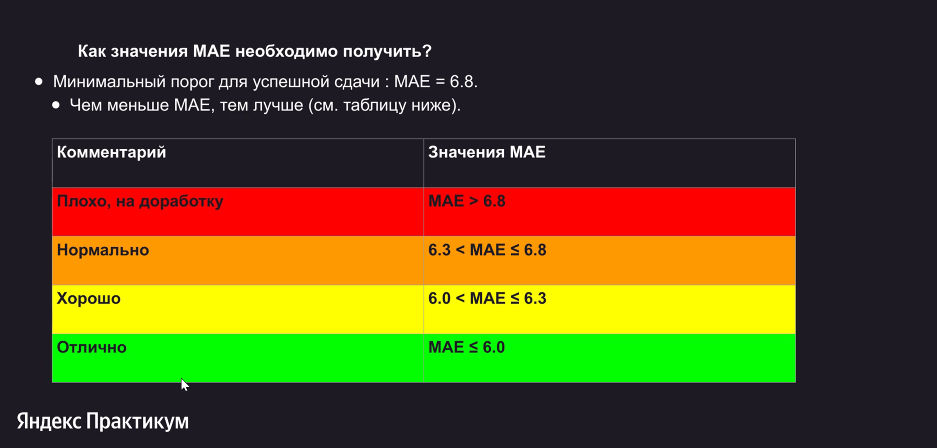

## Сбор и понимание данных

##### Исходные данные

Данные были получены от заказчика. 6 датасетов, каждый отвечает за один из параметров технологического процесса: 
- нагрев электродов
- объем сыпучих материалов
- время добавления сыпучих материалов
- объем газа, который пропускают через расплав
- объем проволоки
- время добавления проволоки в раслпав
- таблица содержащая целевой признак - температура расплава на разных итерациях нагрева.

В разных таблицах разное число строк, так как в некоторых таблицах указаны партии стали, а в других итерации нагрева

Целевой признак: конечная температура при производстве партии стали.

## Моделирование

##### Очистка данных

1. Перед поиском лучшей модели мы удалили аномальные значения, оговоренные с заказчиком: сильно отрицательная мощность и температуры ниже 1500 градусов. Удаление производилось по номеру партии.
2. Мы исключили из датасета с информацией о температуре все партии, в которых не было начально или конечной температуры.
3. Были исключены и все промежуточные температуры. Создана таблица с начальной и конечной температурой каждой партии.
4. В таблице с данными о мощности электродов были сгенерированы признаки: время нагрева, полная мощность, работа
5. Таблица с данными о мощности электродов было агрегирована по ключу.
6. Из всех таблиц были удалены временные метки, так как они не синхронизированы между собой.
7. В таблицах с информацией об объемах сыпучих материалов и проволоки были сгенерированы признаки: число добавленных примесей и общий объем добавленных примесей. Все пропуски заменены нулями - так как это эквивалентно недобавлению примеси. Также были удалены признаки, которые более, чем на 99% заполнены нулями.
8. Все таблицы были объединены по номеру партии (поле key) методом join с параметром inner - в итоговую таблицу попали только те строки, чьи ключи были во всех таблицах.
9. Общий датасет был поделен на тестовую и тренировочную выборкит(25% на 75%), были выделены признаки и целевой признак (конечная температура), из обучающей выборки были удалены аномалии. (сильно выбивающие, редкие, большие или маленькие значения.

##### Поиск наилучшей модели

Были созданы 5 [моделей](#models):
- [Константная](#const)
- [ElasticNet](#lin)
- [Дерево решений](#tree)
- [LightGBM](#lgbm)
- [CatBoost](#CB)

Для каждой, кроме константной с помощью BayesSearchCV были определнны наилучшие параметры и целевая метрика MAE при кроссвалидации при этих параметрах.

Лучший результат при кроссвалидации показала модель LGBM, значени MAE ниже 6. Принято решение получать значение MAE для тестовой выборке на этой модели.

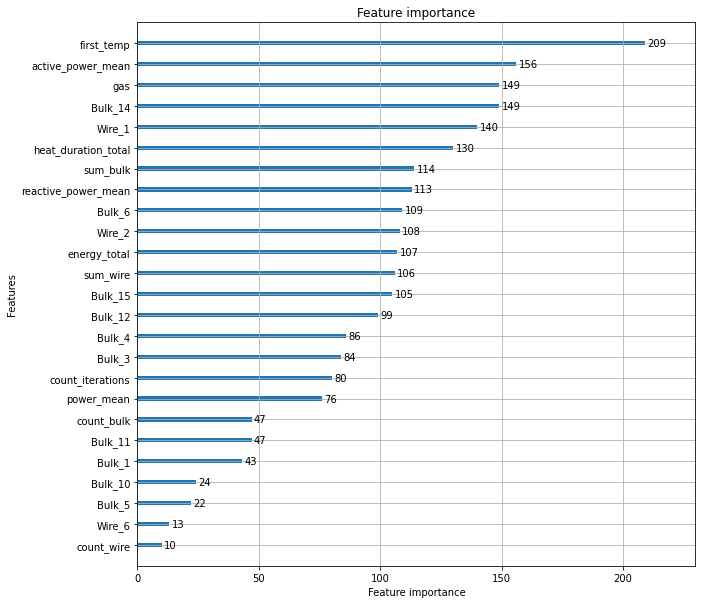

In [693]:
plot_importance(best_model, figsize=(10, 10))
plt.show()

Также можно изучить важность признаков - наиболее значимым является признак - начальная температура. Остальные признаки уже значительно отличаеются от него по важности.